In [118]:
  from google.colab import files

  uploaded = files.upload()
  img = cv2.imread(list(uploaded.keys())[0])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Saving 14.png to 14 (1).png


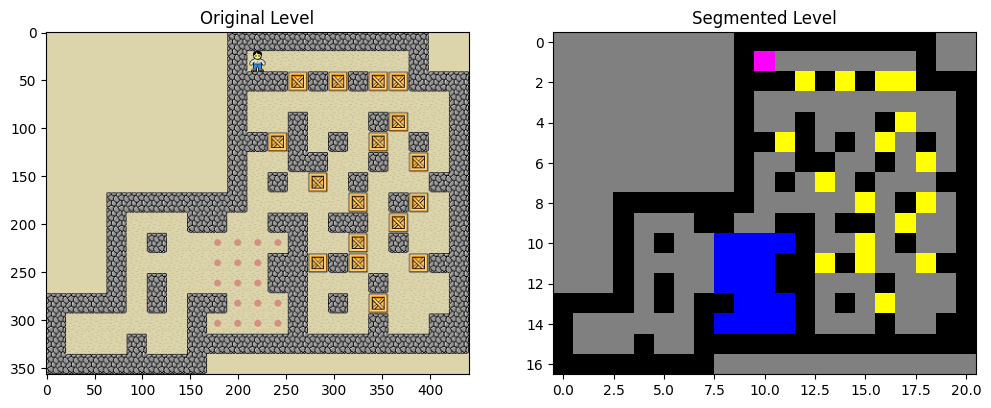

In [138]:
import matplotlib.pyplot as plt
import numpy as np

def classify_tile(std_dev, avg_color):
    # Convert avg_color to list if it's not already
    avg_color = list(avg_color)

    # Relaxed conditions for classification
    if 70 <= std_dev < 80 and np.all(np.isclose(avg_color, [159, 161, 138], atol=10)):
        return 4  # Player
    elif 70 <= std_dev < 80 and np.all(np.isclose(avg_color, [177, 140, 76], atol=10)):
        return 3  # Box
    # Group Outer Floor (0) and Floor (2) together
    elif (20 <= std_dev < 25 and np.all(np.isclose(avg_color, [220, 212, 171], atol=10))) or \
         (20 <= std_dev < 25 and np.all(np.isclose(avg_color, [217, 209, 168], atol=10))):
        return 0  # Treat both as Outer Floor (0)
    # Wall (includes both RGB patterns)
    elif 50 <= std_dev < 60 and (
        np.all(np.isclose(avg_color, [107, 107, 107], atol=10)) or
        np.all(np.isclose(avg_color, [103, 103, 103], atol=10))
    ):
        return 1  # Wall
    elif 25 <= std_dev < 30 and np.all(np.isclose(avg_color, [216, 203, 164], atol=10)):
        return 2  # Box

    else:
        # Print unknown patterns to help with debugging
        print(f"Unknown type: std_dev={std_dev}, avg_color={avg_color}")
        return 5  # Unknown type

# Define colors for each type
COLOR_MAP = {
    0: [128, 128, 128],     # Floor - Gray
    1: [0, 0, 0],       # Wall - Black
    2: [0, 0, 255],     # Storage - Blue
    3: [255, 255, 0],   # Box - Yellow
    4: [255, 0, 255],   # Player - Magenta
    5: [255, 255, 255]  # Unknown - White
}

def process_sokoban_level(block_w, block_h):
    # Get dimensions
    height, width = img.shape[:2]
    grid_h = height // block_h
    grid_w = width // block_w

    # Create analysis grid (2D now, for storing tile type)
    analysis_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
    tile_types = {}

    # Analyze each tile
    for i in range(grid_h):
        for j in range(grid_w):
            # Extract tile
            y1 = i * block_h
            y2 = (i+1) * block_h
            x1 = j * block_w
            x2 = (j+1) * block_w
            tile = img[y1:y2, x1:x2]

            # Simple feature detection
            avg_color = np.mean(tile, axis=(0,1))
            std_dev = np.std(tile)

            # Classification heuristic (adjust these thresholds as needed)
            tile_type = classify_tile(std_dev, avg_color)
            analysis_grid[i,j] = tile_type # Store the type of tile in analysis_grid

    # Visualization
    # Create an RGB representation for visualization (3D)
    rgb_analysis_grid = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)
    for i in range(grid_h):
      for j in range(grid_w):
        rgb_analysis_grid[i,j] = COLOR_MAP[analysis_grid[i,j]]

    # Visualization
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Original Level")
    plt.imshow(img)
    plt.subplot(122)
    plt.title("Segmented Level")
    plt.imshow(rgb_analysis_grid)
    plt.show()

    return analysis_grid

# Example usage
analysis_grid = process_sokoban_level(block_w=21, block_h=21)

Įvertintų lygio dizaino įvairumą ir sudėtingumą naudodama kompiuterinės regos metodus (pvz., objektų tankio analizę, kelių sudėtingumą, simetriją).

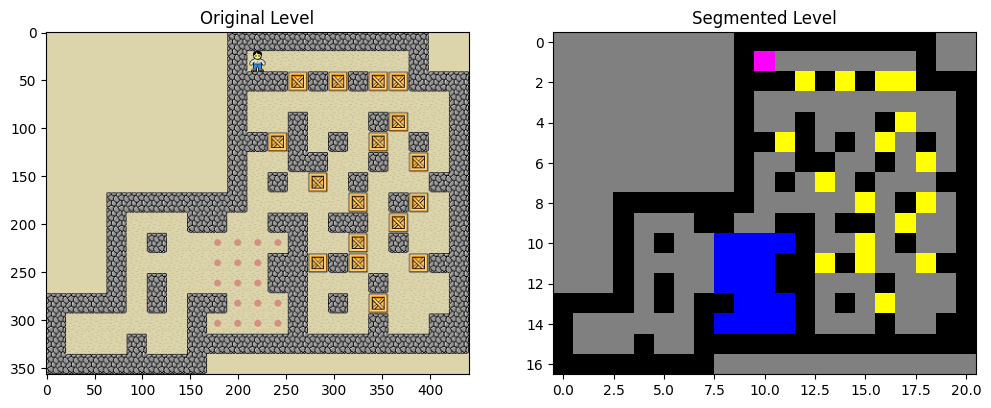

Level Design Evaluation:
Object Counts: {'Floor': 206, 'Wall': 116, 'Storage': 17, 'Box': 17, 'Player': 1, 'Unknown': 0}
Object Density: {'Floor': 0.5770308123249299, 'Wall': 0.32492997198879553, 'Storage': 0.047619047619047616, 'Box': 0.047619047619047616, 'Player': 0.0028011204481792717, 'Unknown': 0.0}
Open Spaces: 206
Wall Density: 0.32492997198879553
Symmetry: Horizontal=False, Vertical=False
Average Box Distance: 8.39
Difficulty Score: 2.03
Variety Score: 0.83


In [139]:
import numpy as np
from scipy.spatial.distance import euclidean

def evaluate_level_design(analysis_grid):
    """
    Evaluate level design variety and difficulty without flattening the grid.
    """
    # Get grid dimensions
    grid_h, grid_w = analysis_grid.shape

    # Count the number of each type of object
    object_counts = {
        "Floor": np.sum(analysis_grid == 0),  # Floor (0)
        "Wall": np.sum(analysis_grid == 1),   # Wall (1)
        "Storage": np.sum(analysis_grid == 2),# Storage (2)
        "Box": np.sum(analysis_grid == 3),    # Box (3)
        "Player": np.sum(analysis_grid == 4), # Player (4)
        "Unknown": np.sum(analysis_grid == 5),# Unknown (5)
    }

    # Object Density Analysis
    total_tiles = grid_h * grid_w
    object_density = {k: v / total_tiles for k, v in object_counts.items()}

    # Pathway Analysis (count open spaces and dead ends)
    open_spaces = object_counts["Floor"]
    wall_density = object_counts["Wall"] / total_tiles

    # Symmetry Analysis (check horizontal and vertical symmetry)
    horizontal_symmetry = np.allclose(analysis_grid, np.flip(analysis_grid, axis=0))
    vertical_symmetry = np.allclose(analysis_grid, np.flip(analysis_grid, axis=1))

    # Distance Analysis (distance between player and boxes)
    player_pos = np.argwhere(analysis_grid == 4)  # Player is type 4
    box_positions = np.argwhere(analysis_grid == 3)  # Box is type 3
    if len(player_pos) > 0 and len(box_positions) > 0:
        player_pos = player_pos[0]  # Take the first player position
        avg_box_distance = np.mean([euclidean(player_pos, box) for box in box_positions])
    else:
        avg_box_distance = 0

    # Difficulty Score (weighted combination of factors)
    difficulty_score = (
        0.4 * wall_density +  # Higher wall density increases difficulty
        0.3 * (1 - open_spaces / total_tiles) +  # Less open space increases difficulty
        0.2 * avg_box_distance +  # Longer distances increase difficulty
        0.1 * (not horizontal_symmetry and not vertical_symmetry)  # Asymmetry increases difficulty
    )

    # Variety Score (based on object distribution)
    unique_objects = np.unique(analysis_grid)
    variety_score = len(unique_objects) / len(COLOR_MAP)  # Normalized by number of possible types

    return {
        "object_counts": object_counts,
        "object_density": object_density,
        "open_spaces": open_spaces,
        "wall_density": wall_density,
        "symmetry": {
            "horizontal": horizontal_symmetry,
            "vertical": vertical_symmetry,
        },
        "avg_box_distance": avg_box_distance,
        "difficulty_score": difficulty_score,
        "variety_score": variety_score,
    }
# Example usage
analysis_grid = process_sokoban_level(block_w=21, block_h=21)
# Evaluate the level design
evaluation = evaluate_level_design(analysis_grid)

# Print evaluation results
print("Level Design Evaluation:")
print(f"Object Counts: {evaluation['object_counts']}")
print(f"Object Density: {evaluation['object_density']}")
print(f"Open Spaces: {evaluation['open_spaces']}")
print(f"Wall Density: {evaluation['wall_density']}")
print(f"Symmetry: Horizontal={evaluation['symmetry']['horizontal']}, Vertical={evaluation['symmetry']['vertical']}")
print(f"Average Box Distance: {evaluation['avg_box_distance']:.2f}")
print(f"Difficulty Score: {evaluation['difficulty_score']:.2f}")
print(f"Variety Score: {evaluation['variety_score']:.2f}")

Sugeneruotų ataskaitą su vizualiai pažymėtais analizės rezultatais, identifikuotomis struktūrinėmis savybėmis ir įžvalgomis apie lygio kokybę bei žaidybinę patirtį.

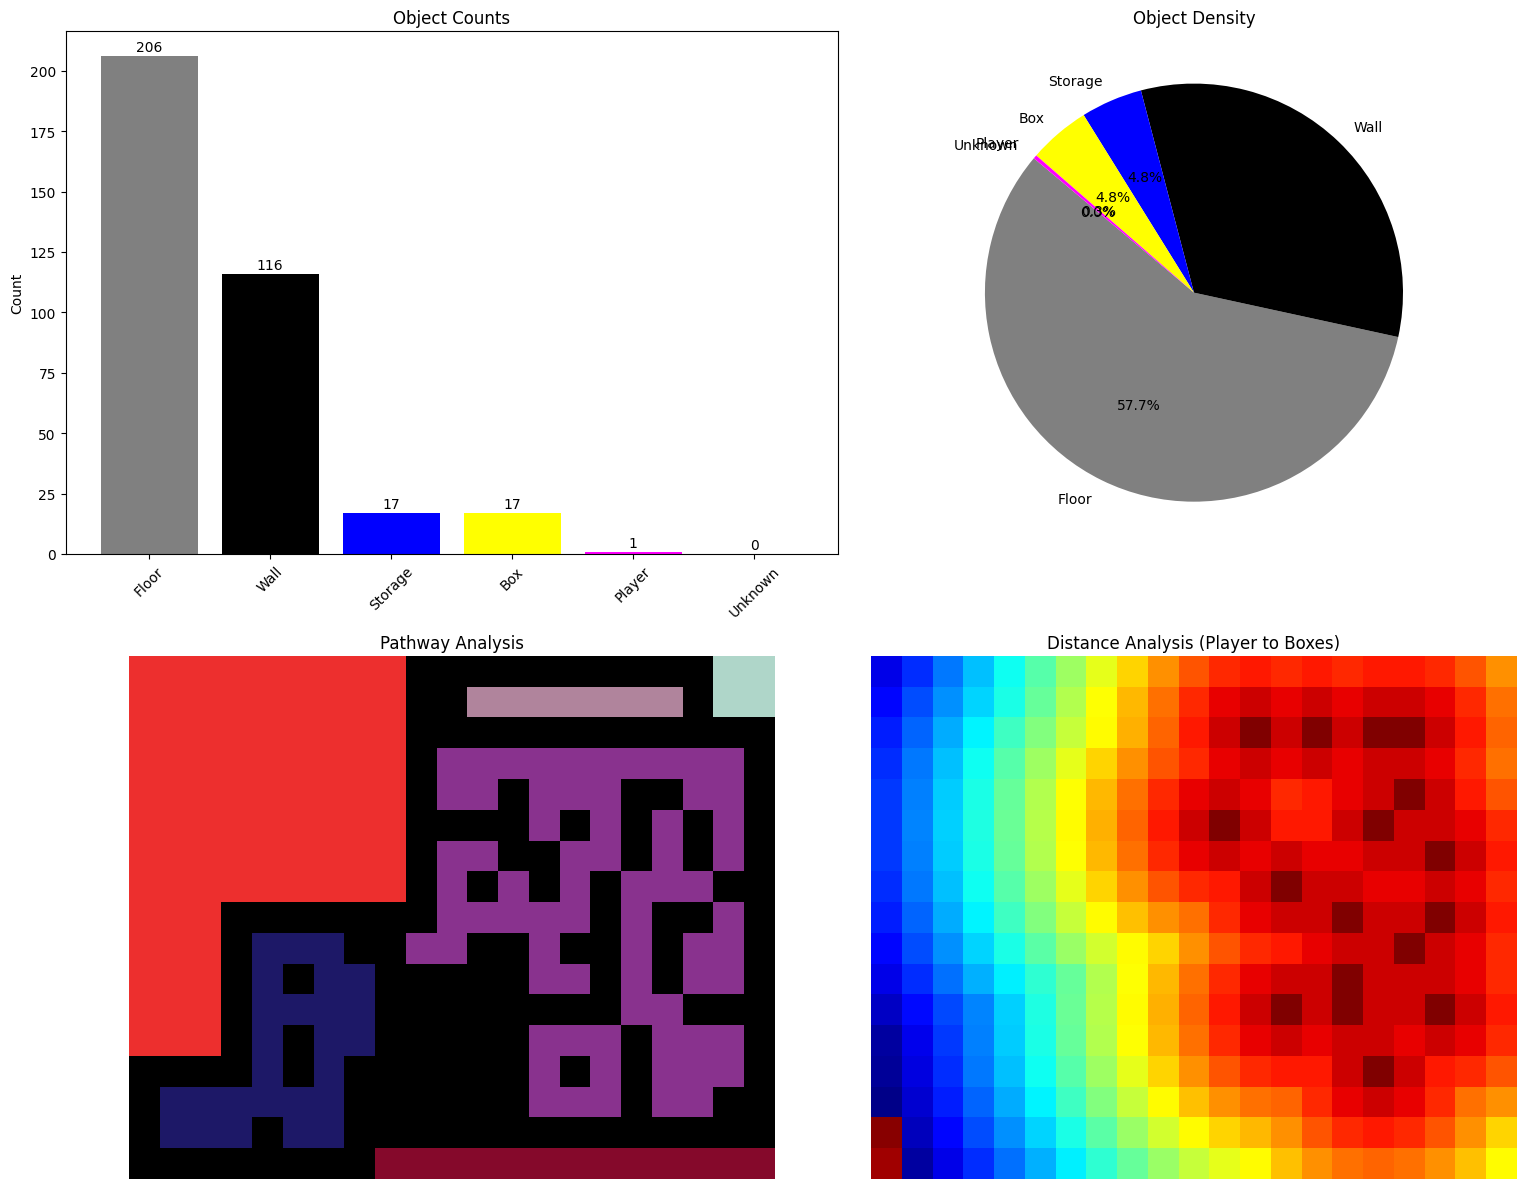

In [145]:
# Cell 3: Generate Visual Report with Four Graphs
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_pathways(analysis_grid):
    """
    Visualizes connected open spaces (pathways) in the analysis grid.
    """
    # Create a mask for open spaces (where the tile type is 0)
    open_spaces_mask = analysis_grid == 0

    # Perform connected component analysis to find connected regions
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(open_spaces_mask.astype(np.uint8), connectivity=8)

    # Create a color map for the connected regions
    color_map = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
    color_map[0] = [0, 0, 0]  # Set background (non-connected) to black

    # Create an output image with colored regions
    output_image = np.zeros((analysis_grid.shape[0], analysis_grid.shape[1], 3), dtype=np.uint8)
    for i in range(1, num_labels):
        output_image[labels == i] = color_map[i]

    return output_image
def visualize_distances(analysis_grid):
    """
    Visualizes the distances from the player to each box in the analysis grid.
    """
    player_pos = np.argwhere(analysis_grid == 4)  # Player is type 4
    box_positions = np.argwhere(analysis_grid == 3)  # Box is type 3

    if len(player_pos) == 0 or len(box_positions) == 0:
        # Handle cases where there are no players or boxes
        return np.zeros((analysis_grid.shape[0], analysis_grid.shape[1], 3), dtype=np.uint8)

    player_pos = player_pos[0]  # Take the first player position

    # Calculate the maximum distance for color scaling
    max_distance = np.max([np.linalg.norm(player_pos - box) for box in box_positions])

    # Create a distance map
    distance_map = np.zeros(analysis_grid.shape[:2], dtype=np.float32)
    for i in range(analysis_grid.shape[0]):
        for j in range(analysis_grid.shape[1]):
            min_dist = float('inf')
            for box in box_positions:
                dist = np.linalg.norm(np.array([i, j]) - box)
                min_dist = min(min_dist, dist)
            distance_map[i, j] = min_dist

    # Normalize distances to 0-255 for visualization
    normalized_distances = (distance_map / max_distance * 255).astype(np.uint8)

    # Apply colormap for visualization
    colored_distance_map = cv2.applyColorMap(normalized_distances, cv2.COLORMAP_JET)

    return colored_distance_map

def generate_visual_report(analysis_grid, evaluation, img, block_w, block_h):
    grid_h, grid_w = analysis_grid.shape

    # Create figure and axes (now 2x2 for four graphs)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    axes = axes.flatten()

    # --- Subplot 1: Object Counts ---
    object_counts_labels = list(evaluation['object_counts'].keys())
    object_counts_values = list(evaluation['object_counts'].values())
    axes[0].bar(object_counts_labels, object_counts_values, color=['gray', 'black', 'blue', 'yellow', 'magenta', 'white'])
    axes[0].set_title("Object Counts")
    axes[0].set_ylabel("Count")
    for i, v in enumerate(object_counts_values):
        axes[0].text(i, v + (max(object_counts_values)/100), f"{v}", ha='center')
    axes[0].tick_params(axis='x', labelrotation=45)

    # --- Subplot 2: Object Density (Pie Chart) ---
    density_labels = list(evaluation['object_density'].keys())
    density_values = list(evaluation['object_density'].values())
    axes[1].pie(density_values, labels=density_labels, autopct='%1.1f%%', startangle=140, colors=['gray', 'black', 'blue', 'yellow', 'magenta', 'white'])
    axes[1].set_title("Object Density")

    # --- Subplot 3: Pathway Analysis ---
    pathway_visualization = visualize_pathways(analysis_grid)
    axes[2].imshow(pathway_visualization)
    axes[2].set_title("Pathway Analysis")
    axes[2].axis('off')  # Hide axis

    # --- Subplot 4: Distance Analysis ---
    distance_visualization = visualize_distances(analysis_grid)
    axes[3].imshow(distance_visualization)
    axes[3].set_title("Distance Analysis (Player to Boxes)")
    axes[3].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Example usage (assuming 'analysis_grid', 'evaluation', 'img', 'block_w', and 'block_h' are defined)
generate_visual_report(analysis_grid, evaluation, img, block_w=21, block_h=21)